In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import networkx as nx
import os
import torch
import sys
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

--- SAM解析開始 ---
使用デバイス: cpu
モデルをロード中...（数分かかる場合があります）
セグメンテーション実行中...
検出された石（領域）の数: 131


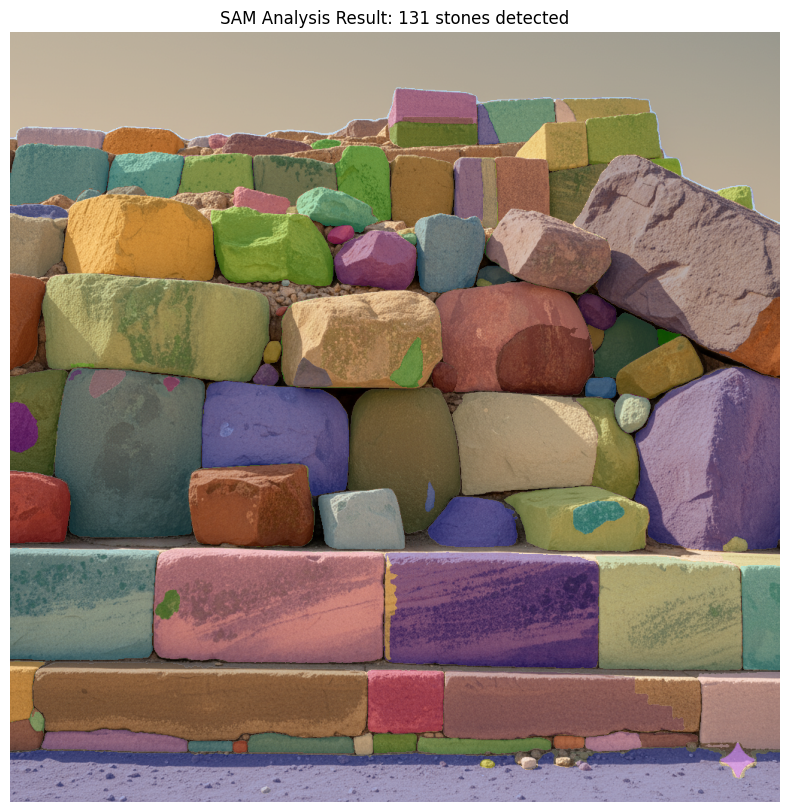

最大面積: 129859 pixels
最小面積: 77 pixels
平均面積: 11059.11 pixels


In [ ]:
def show_anns(anns):
    """
    SAMの出力（マスク）を画像上に可視化するための関数
    """
    if len(anns) == 0:
        return
    # マスクを面積順にソート（大きい順）
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    
    ax = plt.gca()
    ax.set_autoscale_on(False)
    
    # マスク描画設定
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    
    for ann in sorted_anns:
        m = ann['segmentation']
        # ランダムな色を生成
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def process_with_sam(image_path, model_checkpoint):
    """
    SAMを用いて画像をセグメンテーションするメイン関数
    """
    print("--- SAM解析開始 ---")
    
    # 1. 画像読み込み
    image = cv2.imread(image_path)
    if image is None:
        print(f"エラー: 画像が見つかりません: {image_path}")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 2. モデルの準備
    # GPUが使えるならGPUを、使えなければCPUを使用
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"使用デバイス: {device}")
    
    model_type = "vit_h" # 最も高精度なモデル
    
    if not os.path.exists(model_checkpoint):
        print(f"エラー: モデルファイル {model_checkpoint} が見つかりません。ダウンロードしてください。")
        return

    print("モデルをロード中...（数分かかる場合があります）")
    sam = sam_model_registry[model_type](checkpoint=model_checkpoint)
    sam.to(device=device)

    # 3. マスク生成器の作成
    # パラメータ調整: ピラミッドの石は密集しているため、少し感度を調整します
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=32,     # サンプリングする点の数（多いほど細かい）
        pred_iou_thresh=0.86,   # 確信度の閾値
        stability_score_thresh=0.92,
        crop_n_layers=0,        # 画像全体を処理
        crop_n_points_downscale_factor=1,
        min_mask_region_area=100, # 小さすぎるゴミ（ノイズ）を除去
    )

    print("セグメンテーション実行中...")
    masks = mask_generator.generate(image)
    
    print(f"検出された石（領域）の数: {len(masks)}")

    # 4. 結果の可視化
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_anns(masks)
    plt.title(f"SAM Analysis Result: {len(masks)} stones detected")
    plt.axis('off')
    plt.show()
    
    return masks

def main():
    # 画像ファイル名
    img_filename = "images/pyramid1_test.png"
    # ダウンロードしたモデルのパス
    checkpoint_path = "sam_vit_h_4b8939.pth"
    
    masks = process_with_sam(img_filename, checkpoint_path)
    
    if masks is not None and len(masks) > 0:
        # 研究用にデータを分析する例
        # 各マスク（石）の面積情報をリスト化
        areas = [m['area'] for m in masks]
        print(f"最大面積: {max(areas)} pixels")
        print(f"最小面積: {min(areas)} pixels")
        print(f"平均面積: {sum(areas)/len(areas):.2f} pixels")

if __name__ == "__main__":
    main()

画像を読み込み中...
SAMモデルをロード中... (Device: cpu)
石の検出を実行中...
初期検出数: 131 個


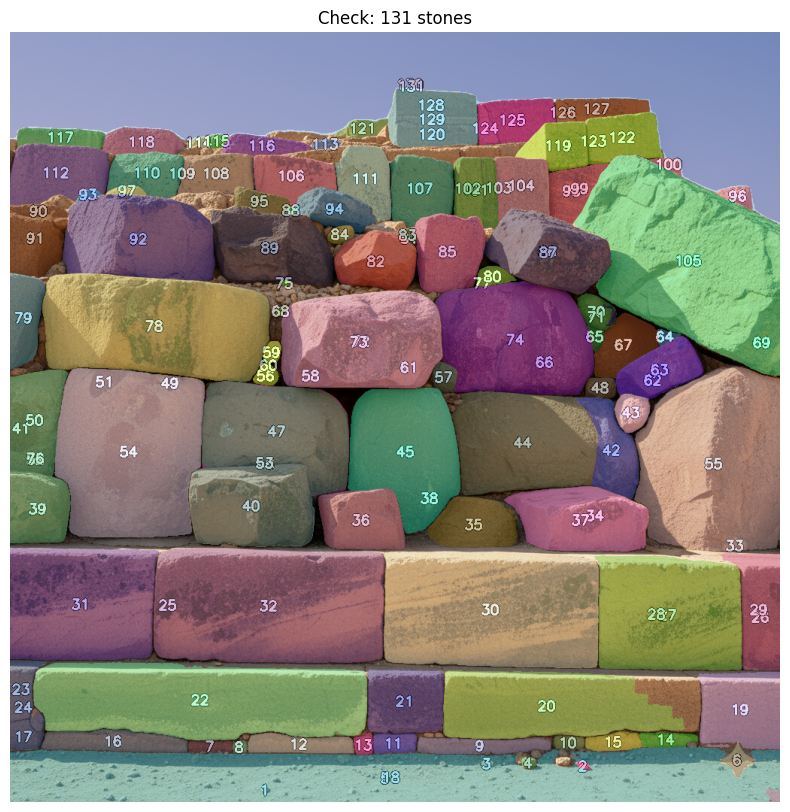

------------------------------------------------------------
【修正モード】削除したい石（誤認識）の番号を入力してください。
例: '3 5 12' (スペース区切り) / 完了なら何も入力せず Enter
------------------------------------------------------------
-> 19 個削除しました。IDを詰め直します。


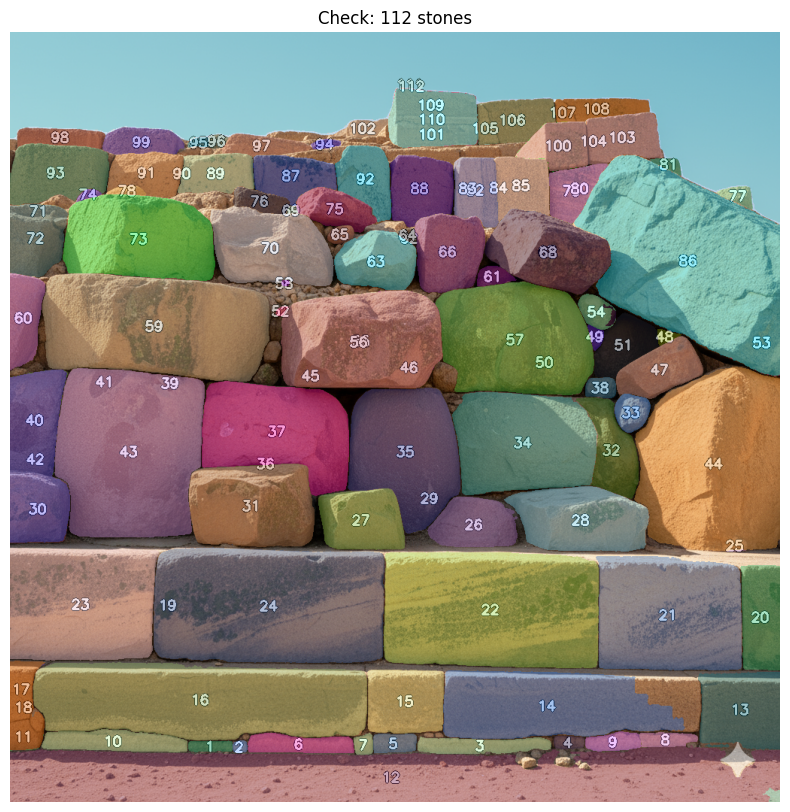

------------------------------------------------------------
【修正モード】削除したい石（誤認識）の番号を入力してください。
例: '3 5 12' (スペース区切り) / 完了なら何も入力せず Enter
------------------------------------------------------------
-> 11 個削除しました。IDを詰め直します。


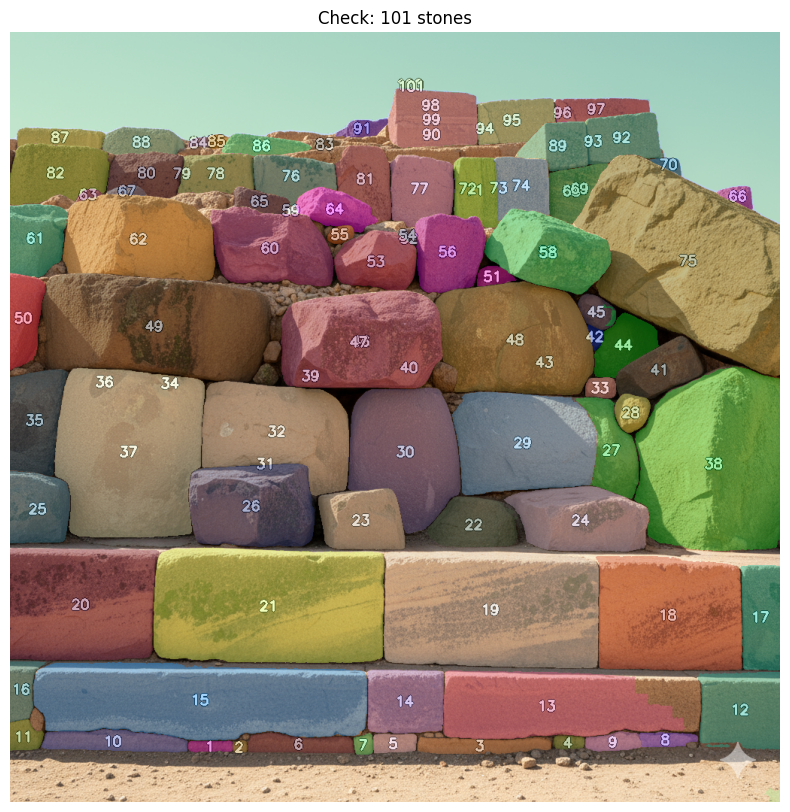

------------------------------------------------------------
【修正モード】削除したい石（誤認識）の番号を入力してください。
例: '3 5 12' (スペース区切り) / 完了なら何も入力せず Enter
------------------------------------------------------------
-> 5 個削除しました。IDを詰め直します。


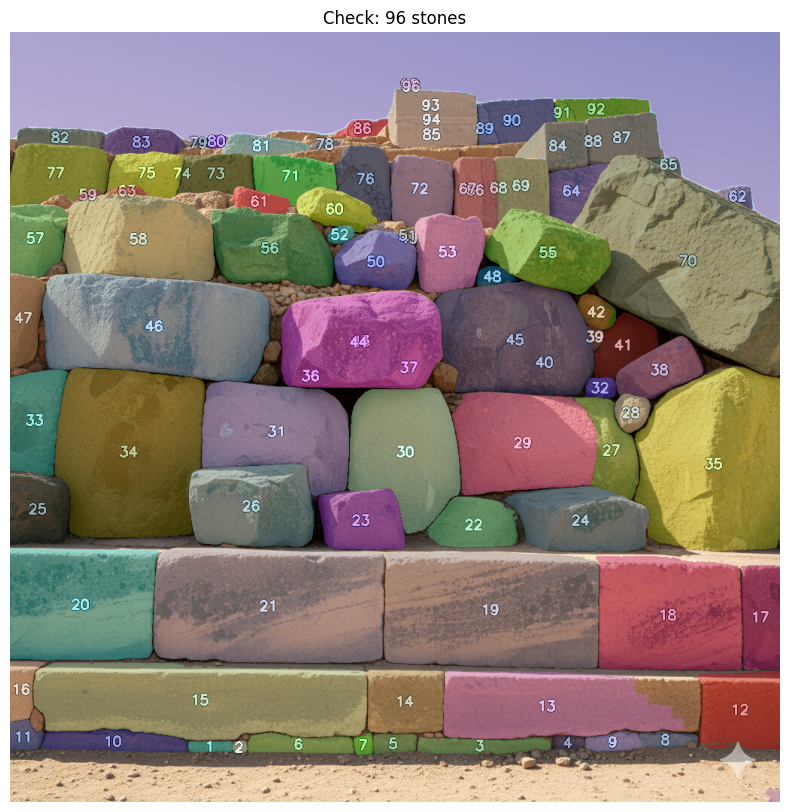

------------------------------------------------------------
【修正モード】削除したい石（誤認識）の番号を入力してください。
例: '3 5 12' (スペース区切り) / 完了なら何も入力せず Enter
------------------------------------------------------------
-> 3 個削除しました。IDを詰め直します。


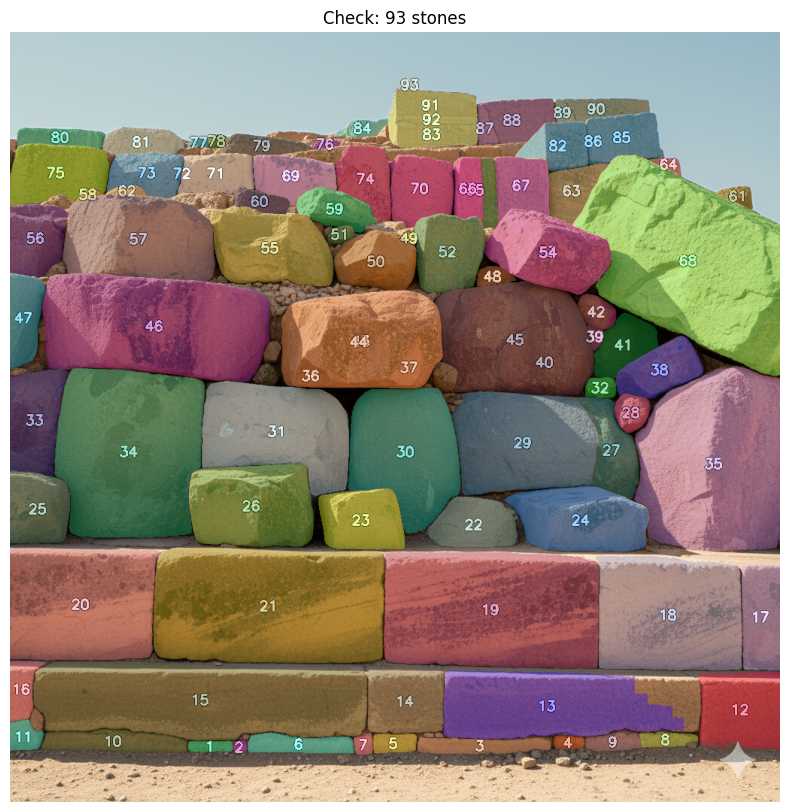

------------------------------------------------------------
【修正モード】削除したい石（誤認識）の番号を入力してください。
例: '3 5 12' (スペース区切り) / 完了なら何も入力せず Enter
------------------------------------------------------------
-> 1 個削除しました。IDを詰め直します。


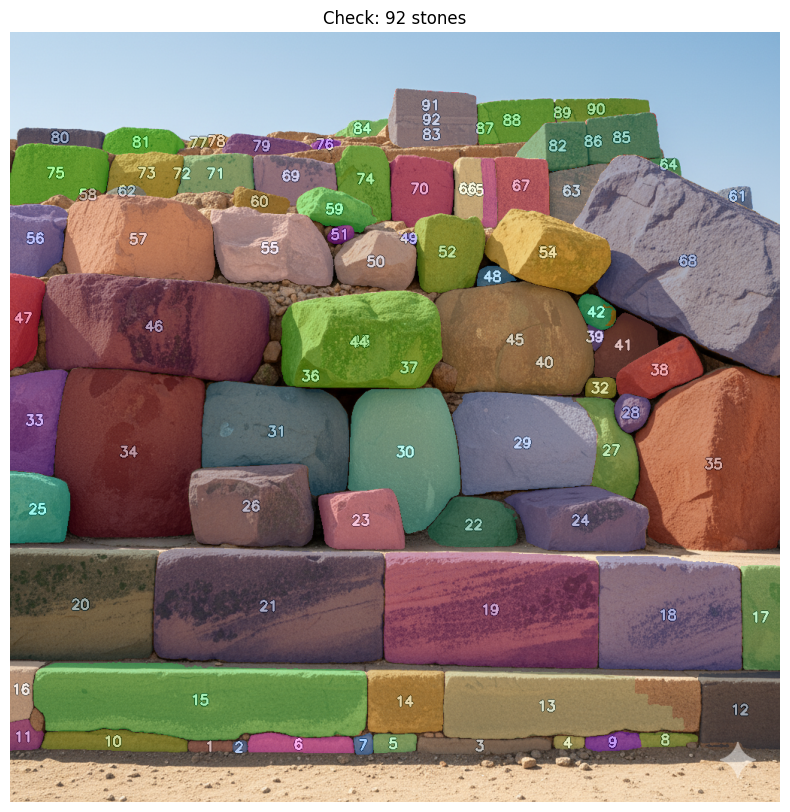

------------------------------------------------------------
【修正モード】削除したい石（誤認識）の番号を入力してください。
例: '3 5 12' (スペース区切り) / 完了なら何も入力せず Enter
------------------------------------------------------------
修正完了。データを保存します。
最終データ処理完了。
残った石の面積リスト: [816, 292, 3238, 667, 1397, 3108, 633, 1304, 1548, 4611, 1473, 10333, 23621, 8312, 39626, 2507, 6993, 27767, 42336, 28077, 44824, 6436, 8094, 13092, 6971, 16628, 6079, 1881, 22347, 21378, 21805, 1017, 8688, 39006, 40466, 1337, 1690, 5894, 459, 9980, 4521, 1718, 24746, 25105, 26267, 36495, 4687, 997, 216, 6904, 686, 8272, 12714, 12991, 13796, 6389, 19802, 310, 4049, 1811, 869, 499, 3795, 527, 4634, 2935, 4977, 50249, 5128, 6632, 4555, 8895, 4780, 5293, 8749, 408, 309, 406, 2395, 2472, 3186, 4427, 3504, 1156, 5500, 9923, 1025, 5095, 617, 3032, 4019, 8275]


In [11]:
# --- 1. ユーティリティ関数（ソート・可視化） ---

def sort_masks_bottom_up(masks):
    """
    マスクを画像の下（Y座標が大きい方）から上に向かって並べ替える
    """
    # bbox は [x, y, w, h]
    # y (bbox[1]) が大きい順（降順）＝ 画像の下から順
    return sorted(masks, key=lambda x: x['bbox'][1], reverse=True)

def visualize_labeled_masks(image, masks, title="Labeled Stones"):
    """
    画像上の各マスクにID番号を振って表示する
    """
    vis_img = image.copy()
    overlay = vis_img.copy()
    
    # フォント設定
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.6
    thickness = 2
    
    for i, mask in enumerate(masks):
        idx = i + 1 # IDは1から
        
        # マスクの重心計算
        y_indices, x_indices = np.where(mask['segmentation'])
        if len(y_indices) == 0: continue
        center_y = int(np.mean(y_indices))
        center_x = int(np.mean(x_indices))
        
        # 色塗り（ランダム色）
        color = np.random.randint(0, 255, (3,)).tolist()
        overlay[mask['segmentation']] = color
        
        # ID描画（視認性確保のため黒縁＋白文字）
        text = str(idx)
        text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
        text_x = center_x - text_size[0] // 2
        text_y = center_y + text_size[1] // 2
        
        cv2.putText(vis_img, text, (text_x, text_y), font, font_scale, (0, 0, 0), thickness + 2)
        cv2.putText(vis_img, text, (text_x, text_y), font, font_scale, (255, 255, 255), thickness)

    # 重ね合わせ
    cv2.addWeighted(overlay, 0.4, vis_img, 0.6, 0, vis_img)

    plt.figure(figsize=(10, 10))
    plt.imshow(vis_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# --- 2. メイン処理フロー ---

def main():
    image_path = "images/pyramid1_test.png"
    checkpoint_path = "sam_vit_h_4b8939.pth" # モデルファイルのパス

    # --- Step A: 画像とモデルの準備 ---
    if not os.path.exists(image_path):
        print(f"エラー: 画像 {image_path} が見つかりません。")
        return
    if not os.path.exists(checkpoint_path):
        print(f"エラー: モデル {checkpoint_path} が見つかりません。")
        return

    print("画像を読み込み中...")
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"SAMモデルをロード中... (Device: {device})")
    
    sam = sam_model_registry["vit_h"](checkpoint=checkpoint_path)
    sam.to(device=device)

    # --- Step B: SAMによる自動検出 ---
    print("石の検出を実行中...")
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=32,
        pred_iou_thresh=0.86,
        stability_score_thresh=0.92,
        crop_n_layers=0,
        min_mask_region_area=100,
    )
    
    # ここでマスク（masks）が生成されます
    masks = mask_generator.generate(image_rgb)
    print(f"初期検出数: {len(masks)} 個")

    # --- Step C: 対話型修正ループ ---
    # まず下から順に並べ替え
    current_masks = sort_masks_bottom_up(masks)

    while True:
        # 現在の状態を表示
        visualize_labeled_masks(image_rgb, current_masks, title=f"Check: {len(current_masks)} stones")
        
        print("-" * 60)
        print("【修正モード】削除したい石（誤認識）の番号を入力してください。")
        print("例: '3 5 12' (スペース区切り) / 完了なら何も入力せず Enter")
        print("-" * 60)
        
        user_input = input("削除番号 >> ")
        
        if not user_input.strip():
            print("修正完了。データを保存します。")
            break
        
        try:
            # 入力IDをセットに変換
            remove_ids = set(map(int, user_input.split()))
            
            # 削除対象以外のマスクを残すリスト再構築
            new_masks = []
            for i, mask in enumerate(current_masks):
                idx = i + 1 # 表示されているID
                if idx not in remove_ids:
                    new_masks.append(mask)
            
            removed_count = len(current_masks) - len(new_masks)
            print(f"-> {removed_count} 個削除しました。IDを詰め直します。")
            
            current_masks = new_masks
            
            if len(current_masks) == 0:
                print("全てのデータが削除されました。")
                break
                
        except ValueError:
            print("エラー: 数字を入力してください。")

    # --- Step D: 結果の活用 ---
    # ここに最終的なデータ(current_masks)が残ります
    print("最終データ処理完了。")
    # 例: 面積のリストを表示
    final_areas = [m['area'] for m in current_masks]
    print(f"残った石の面積リスト: {final_areas}")

if __name__ == "__main__":
    main()

In [12]:
from scipy.signal import argrelextrema
from scipy.stats import gaussian_kde

In [14]:
def add_centroid_and_group_tiers(masks, df_stones):
    """
    SAMのマスク情報から重心を計算し、Y座標に基づいて段(Tier)をグルーピングする関数
    """
    # 1. 重心(Centroid)の計算
    # SAMの出力(masks)がリスト形式で保持されていると仮定
    # bboxは [x, y, w, h] の形式
    
    centroids_y = []
    centroids_x = []
    
    for m in masks:
        x, y, w, h = m['bbox']
        # 簡易的にバウンディングボックスの中心を重心とする
        cy = y + h / 2
        cx = x + w / 2
        centroids_y.append(cy)
        centroids_x.append(cx)
    
    # データフレームに追加
    df_stones['Centroid_X'] = centroids_x
    df_stones['Centroid_Y'] = centroids_y

    # 2. Y座標の分布（密度）を推定して段の境界を見つける
    y_values = df_stones['Centroid_Y'].values
    
    # カーネル密度推定(KDE)で分布を滑らかにする
    # bandwidthはデータのばらつき具合で調整が必要かもしれません(デフォルトで一旦実行)
    kde = gaussian_kde(y_values, bw_method=0.1) 
    
    # 評価するY座標の範囲（画像の上から下まで）
    y_grid = np.linspace(min(y_values)-10, max(y_values)+10, 500)
    y_density = kde(y_grid)
    
    # 密度の極小値（谷）を検出 = これが段の境界線になる
    # orderは「どれくらいの範囲で最小か」のパラメータ。石のサイズに応じて調整。
    valleys_indices = argrelextrema(y_density, np.less, order=10)[0]
    valley_y_values = y_grid[valleys_indices]
    
    # 3. 境界線に基づいてラベリング
    # 境界線リストに最小値と最大値を加えて区間を作る
    boundaries = sorted([-np.inf] + list(valley_y_values) + [np.inf])
    
    # 下から順に1段目, 2段目...とするため、画像座標(Yは下が大きい)を考慮して逆順にするか、
    # cutした後にマッピングを変更する。ここではpd.cutを使用。
    
    # 区間ごとにビン分割
    df_stones['Tier_Group'] = pd.cut(df_stones['Centroid_Y'], bins=boundaries, labels=False)
    
    # 画像座標系ではYが大きいほど「下」なので、グループIDが大きい方が「下の段」になることが多い。
    # ユーザーの要望「下から1段目、2段目...」に合わせるため、IDを振り直す
    # 現在のグループIDのユニーク値を降順（Yが大きい順＝下から順）に並べ替え
    unique_tiers = sorted(df_stones['Tier_Group'].unique(), reverse=True)
    tier_map = {original: i+1 for i, original in enumerate(unique_tiers)}
    
    df_stones['Tier'] = df_stones['Tier_Group'].map(tier_map)
    
    # 不要な一時列を削除
    df_stones.drop(columns=['Tier_Group'], inplace=True)
    
    return df_stones, y_grid, y_density, valley_y_values

# --- 実行ブロック ---

# df と current_masks (SAMの出力リスト) が存在すると仮定しています
# まだdfを作成していない場合は、前段のコードで current_masks から df を作成している部分を確認してください
# ここでは既存の df を使う想定です

if 'current_masks' in locals() and 'df' in locals():
    print("垂直方向のグルーピングを開始します...")
    
    # 関数実行
    df, y_grid, density, boundaries = add_centroid_and_group_tiers(current_masks, df)
    
    # 結果の確認：分布と境界線の可視化
    plt.figure(figsize=(10, 6))
    
    # 1. Y座標のヒストグラムと密度曲線
    plt.plot(y_grid, density, label='Y-Coord Density (KDE)', color='blue')
    plt.hist(df['Centroid_Y'], bins=30, density=True, alpha=0.3, color='gray', orientation='vertical', label='Y-Coord Hist')
    
    # 2. 検出された境界線（段の区切り）をプロット
    for b in boundaries:
        plt.axvline(x=b, color='red', linestyle='--', alpha=0.7, label='Tier Boundary' if b == boundaries[0] else "")
        
    plt.title("Estimated Tier Structure based on Y-Coordinates")
    plt.xlabel("Y Coordinate (Image Height)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    
    # 画像座標に合わせてY軸を反転させる（上がY=0）と直感的ですが、
    # ヒストグラムとしてはX軸にY座標をとっているため、このままで「右側が画像の下部」と解釈してください
    plt.show()

    # --- 結果の確認画像（散布図） ---
    plt.figure(figsize=(10, 8))
    # Y軸を反転して画像と同じ向きにする
    plt.gca().invert_yaxis()
    scatter = plt.scatter(df['Centroid_X'], df['Centroid_Y'], c=df['Tier'], cmap='tab10', s=100, alpha=0.8, edgecolors='k')
    plt.colorbar(scatter, label='Tier Number (1=Bottom)')
    
    # 各点にTier番号を表示
    for idx, row in df.iterrows():
        plt.text(row['Centroid_X'], row['Centroid_Y'], str(int(row['Tier'])), fontsize=8, ha='center', va='center', color='white')
        
    plt.title("Stone Tier Grouping Result")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.axis('equal') # アスペクト比を保持
    plt.grid(True, alpha=0.3)
    plt.show()

    print("--- 各段の石の数 ---")
    print(df['Tier'].value_counts().sort_index())
    
else:
    print("エラー: 'current_masks' または 'df' が見つかりません。SAMの実行セルを先に実行してください。")

エラー: 'current_masks' または 'df' が見つかりません。SAMの実行セルを先に実行してください。
